In [64]:
# import brian2 as b2
import numpy as np
import matplotlib.pyplot as plt
# from neurodynex.leaky_integrate_and_fire import LIF
# from neurodynex.tools import input_factory, plot_tools

default_pars = {'V_th': -55.0, 'V_reset': -75.0, 'tau_m': 10.0,
                'g_L': 10.0, 'V_init': -75.0, 'E_L': -75.0, 'tref': 2.0,
                'T': 400.0, 'dt': 0.1,
                'range_t': np.arange(2000)}



def get_noisy_current_OU( t_end, unit_time, I_stim0, I_avg, tau_n = 10, sig_noise = 1, myseed=10):

    """Creates a noise injection using Ornstein-Uhlenbeck (OU) process.
    Args:
        t_end (int): end of the step in ms
        unit_time (Brian2 unit): unit of t_start and t_end. e.g. 0.1*brian2.ms
        I_stim0 (int): inital value for the injected current
        unit (Quantity): unit of the current usially uA
        tau_n (Quantity): noise time constant
        sig_noise (Quantity): standard deviation of noise 

    Returns:
        TimedArray: Brian2.TimedArray
    """


    # Retrieve simulation parameters
    dt = 1. * unit_time
    Lt =  t_end

    # Set random seed
    if myseed:
        np.random.seed(seed=myseed)
    else:
        np.random.seed()

    # Generate GWN
    # we divide here by 1000 to convert units to sec.
    I_gwn = np.zeros((int(Lt/dt),1))


    I_stim = np.zeros((int(t_end/dt)))
    I_stim[0] = I_stim0
 
    for t_ in range(0,int(t_end/dt)):
        I_stim[t_]=I_avg+((I_avg-I_stim[t_-1])/tau_n)+sig_noise*np.random.normal(0,1)
    
    I_gwn[:,0] = I_stim

    tmp = I_gwn
    curr = tmp #TimedArray(tmp, dt=1. * unit_time)
    return curr

default_pars = {'V_th': 0.0279, 'V_reset': -0.0279, 'tau_m': 10.0,
                'g_L': 1.0, 'V_init': 0, 'E_L': 0.0, 'tref': 2.0,
                'T': 500.0, 'dt': 0.1,
                'range_t': np.arange(5000),'seed':0}

def run_LIF(pars,  stop=False):
    """
    Simulate the LIF dynamics with external input current

    Args:
    pars       : parameter dictionary
    Iinj       : input current [pA]. The injected current here can be a value
                    or an array
    stop       : boolean. If True, use a current pulse

    Returns:
    rec_v      : membrane potential
    rec_sp     : spike times
    """

    # Set parameters
    V_th, V_reset = pars['V_th'], pars['V_reset']
    tau_m, g_L = pars['tau_m'], pars['g_L']
    V_init, E_L = pars['V_init'], pars['E_L']
    dt, range_t = pars['dt'], pars['range_t']
    T = pars['T']
    # print(T)
    seed = pars['seed']
    Lt = range_t.size
    tref = pars['tref']
    # Initialize voltage
    v = np.zeros(Lt)
    v[0] = V_init

    SNR = 0.6
    Iinj = SNR*get_noisy_current_OU(int(T), dt,0,0,myseed=seed)+np.sqrt(1-SNR)*get_noisy_current_OU(int(T), dt,0,0,myseed=seed)
    rec_spikes = []  # record spike times
    tr = 0.  # the count for refractory duration

    for it in range(Lt - 1):

        if tr > 0:  # check if in refractory period
            v[it] = V_reset  # set voltage to reset
            tr = tr - 1 # reduce running counter of refractory period

        elif v[it] >= V_th:  # if voltage over threshold
            rec_spikes.append(it)  # record spike event
            v[it] = V_reset  # reset voltage
            tr = tref / dt  # set refractory time

        # Calculate the increment of the membrane potential
        dv = (-(v[it]-E_L)+Iinj[it]/g_L)* (dt / tau_m)

        # Update the membrane potential
        v[it + 1] = v[it]+dv

        # Get spike times in ms
        rec_spikes_ = np.array(rec_spikes) * dt

    return v, rec_spikes_,Iinj
spikes_t_s_u = []
N_stim = 10
for i in range(N_stim):
    default_pars['seed']=i
    v,spikes,I =run_LIF(default_pars,)
    spikes_t_s_u.append(spikes)
# plt.plot(v)
# plt.scatter(np.array(spikes/0.1-0.01,dtype=np.int32),v[np.array(spikes/0.1-0.01,dtype=np.int32)])
# plt.show()
# plt.plot(I)
# plt.show()

In [68]:
spikes_t_s_u

[array([ 15.4,  24.7,  32.9,  42.1,  59.8,  63.6,  67.1,  73.3, 100.7,
        104.3, 127.7, 132. , 153.4, 165.9, 169.8, 184.8, 212.4, 223.5,
        257.1, 266.6, 318.4, 327.4, 348.1, 362.2, 374.3, 433.6, 441.1,
        448.8, 488.7]),
 array([  6.3,  14.6,  17.7,  22.6,  27.3,  31.5,  44.1,  47.4,  57.4,
         84.3,  94.1, 110.2, 123. , 128. , 132.4, 141.8, 144.3, 147.9,
        179.3, 184.9, 217.7, 225.3, 241.5, 263.4, 302.3, 306.1, 311.2,
        316.9, 333.5, 383.1, 391.1, 395.1, 401.4, 404.3, 407.8, 415.4,
        418. , 422.4, 429.8, 447. , 449.9, 452.9, 460.7, 464.5, 470.7,
        475.9, 485.8]),
 array([ 16.9,  36.8,  39.4, 108.3, 131.3, 135.4, 175.5, 178.4, 187.5,
        190.3, 200.5, 205.2, 257.1, 261.7, 265.4, 269.5, 275.6, 278.2,
        297.1, 311.4, 325.2, 337.5, 387.3, 392.9, 397. , 402.1, 410.9,
        428.9, 431.7, 445.5, 452.3, 455.5, 459.6, 476.5]),
 array([ 21.7,  24.6,  29. ,  45.6,  59.9,  66.8,  90.6,  96.1, 103.5,
        147.5, 162.2, 218.6, 233.2, 239.8

29
47
34
24
48
39
50
27
47
49


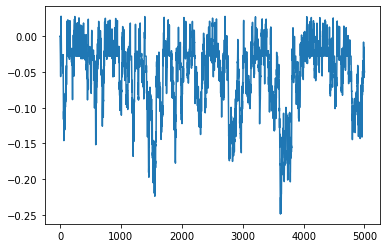

In [67]:
for i in spikes_t_s_u:
    print(len(i)) 
plt.plot(v)
# plt.plot(get_noisy_current_OU(400, dt,0,0,myseed=1))


In [11]:
1. Generate 100 spike trains for different OU inputs 
2. generate 100 spike for the same OU input 

(100, 34)

In [11]:
from scipy.io import loadmat
import numpy as np
spikesmat_tsr = loadmat("C:/Users/Nishant Joshi/Documents/Mariam/spikes_tsr.mat")
spikesmat_tsu = loadmat("C:/Users/Nishant Joshi/Documents/Mariam/spikes_tsu.mat")


In [12]:
print(len(spikesmat_tsu['t_s_u'][0][0]))
# print('--------------------1-----1-----1')

1000


In [13]:
spikesmat_tsu['t_s_u'][0][0].shape

(1000, 1)

In [14]:
test_spike_t_s_u = np.array(spikesmat_tsu['t_s_u'])[0][0][:10]
test_spike_t_s_r = np.array(spikesmat_tsr['t_s_r'])[0][0][:10]


In [42]:
for i in test_spike_t_s_u:
    print(len(i[0][0]))

554
491
473
519
528
504
523
515
490
503


In [16]:
s1 = np.repeat(np.expand_dims(np.array([1,2]),axis=0).T,2,axis=1)
s2 = np.repeat(np.expand_dims(np.array([1,2]),axis=1).T,2,axis=0)
print(s1-s2+10/(2*(0.1**2)))


[[500. 499.]
 [501. 500.]]


In [17]:
def auto_corr(plot_taus,sigma,t_s):
    Ntr = np.shape(t_s)[1]
    
    # auto_corr = np.zeros((len(plot_taus),1))
    auto_corr = []
    for k in range(Ntr):
        auto_corr_temp = []
        ST1= t_s[0][k][0]

        N = len(ST1)

        s1 = np.repeat(np.expand_dims(ST1.T,axis=0).T,N,axis=1)
        s2 = np.repeat(np.expand_dims(ST1,axis=1).T,N,axis=0)
        for i in range(len(plot_taus)):
            tau = plot_taus[i]
            cons_a = np.exp(-((s1-s2+tau)**2)/(2*(sigma**2)))
            cons_b = np.exp(-(tau)**2/(2*(sigma**2)))
            auto_corr_temp.append((np.sum(cons_a)-N*cons_b)/(np.sqrt(2*np.pi)*sigma))
        auto_corr.append(auto_corr_temp)
    auto_corr=np.mean(auto_corr,axis=0)
    return np.expand_dims(auto_corr,axis=1)

def cross_corr(plot_taus,sigma,t_s):
    
    Ntr =np.shape(t_s)[1]
    cross_corr = np.zeros((len(plot_taus),1))
    t_s1 = t_s[0]
    t_s2 = t_s[0][1:]
    for k in range(Ntr-1):
        ST1 = t_s1[k][0]
        ST2 = t_s2[k][0]
        l1 = len(ST1)
        l2 = len(ST2)
        sig1 = np.expand_dims(ST1,axis=0)
        sig2 = np.expand_dims(ST2,axis=0)
        s1 = np.repeat(sig1.T,l2,axis=1)
        s2 = np.repeat(sig2,l1,axis=0)

        for i in range(len(plot_taus)):
            tau = plot_taus[i]
            cons = np.exp(-(s1-s2+tau)**2/(2*sigma**2))
            cross_corr[i] +=np.sum(cons)/(np.sqrt(2*np.pi)*sigma)

    cross_corr=cross_corr/(Ntr-1)
    return cross_corr

def My_DFT_custom_freqs(t,x,freqs):
    # %MY_DFT Gives the discrete fouriertransform for an input of a time vector t
    # % and the function x that will be fouriertransformed. 
    # %   Also we could introduce a custom freqs vector in the future to
    # %   customize the frequency resolution.
    print(x.shape)
    f_coefs = np.zeros((1,len(freqs)))
    
    
    T_seq = np.max(t) - np.min(t)
    for k in range(f_coefs.shape[1]):
        # print(np.exp(-1j*2*np.pi*freqs[k]*t[:-1]))
        f_coefs[0,k] = np.real(np.mean(x[0,:-1]*(np.exp(-1j*2*np.pi*freqs[k]*t[:-1]))))
    
    return f_coefs


In [21]:
num_tau_min  = -100  #% (ms)
num_tau_max =  100  #% (ms)
num_dtau    =  0.1  #% (ms)

                  
num_taus = np.arange(num_tau_min,num_tau_max+num_dtau,num_dtau)

sigma =0.01
autocor_num_u = auto_corr(num_taus,sigma,test_spike_t_s_u[:10].T)  # what is sigma?
crosscorr_num_r  = cross_corr(num_taus, sigma, test_spike_t_s_r[:10].T)#
            

In [23]:
autocor_num_u.shape

(2001, 1)

In [143]:
num_tau_min  = -100  #% (ms)
num_tau_max =  100  #% (ms)
num_dtau    =  0.1  #% (ms)

                  
num_taus = np.arange(num_tau_min,num_tau_max+num_dtau,num_dtau)

sigma =0.01
autocor_num_u = auto_corr(num_taus,sigma,test_spike_t_s_u[:10].T)  # what is sigma?
crosscorr_num_r  = cross_corr(num_taus, sigma, test_spike_t_s_r[:10].T)#
            

In [24]:
     
freq_max = 500 # Max frequency to evaluate (Hz)

delta_f = 1 



# % Assigning vectors
freqs = np.arange(0,freq_max+delta_f, delta_f) #;
 
Nf = len(freqs) #; % number of frequencies
 
num_delta_f = 1/(num_tau_max-num_tau_min)*1000
num_freqs   = np.arange(0,(1/num_dtau*1000/2)+num_delta_f, num_delta_f)/1000
steps = 10000
dt = 0.1
T_seq_korrigiert = steps*dt
N = 1
Ntr = 10
FiR_u = np.zeros((1,Ntr))
FiR_r = np.zeros((1,Ntr))


for j  in range(Ntr):
   FiR_u[0,j] = len(test_spike_t_s_u.T[0,j][0])/T_seq_korrigiert
   FiR_r[0,j] = len(test_spike_t_s_r.T[0,j][0])/T_seq_korrigiert

FiR_u_mean = np.mean(FiR_u)
FiR_r_mean = np.mean(FiR_r)
# % Fouriertranformations

Off_Fac_num_u = 1/(num_tau_max-num_tau_min)*FiR_u_mean*T_seq_korrigiert

# %  Numeric functions
auto_four_u_temp   = np.real(My_DFT_custom_freqs(num_taus, autocor_num_u.T, num_freqs))
auto_four_u  = np.real(auto_four_u_temp)

cross_four_r_temp  = np.real(My_DFT_custom_freqs(num_taus, crosscorr_num_r.T, num_freqs))
cross_four_r = np.real(cross_four_r_temp)

Info_pn_cor2  = -1/2*np.log2(1-(cross_four_r/(auto_four_u+Off_Fac_num_u))) # % Hier repeaats


(1, 2001)


(1, 2001)


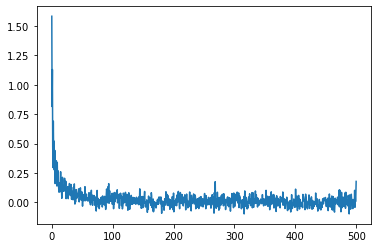

In [25]:
plt.plot(num_freqs*100,Info_pn_cor2[0])